In [79]:
import numpy as np
import random as rnd
import scipy.spatial.distance as distance
import math
import scipy.stats as stats
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plot
import scipy

In [104]:
def myMahalanobis(x, mu, alpha):
    return np.matmul((x - mu).transpose(),np.matmul(alpha, x - mu))

In [119]:
def create(accumulators, ages, alphas, comProbs, covDets, K, mus, sigmaInv, x):
    accumulators[K] = 1
    ages[K] = 1
    alphas[K] = sigmaInv * np.identity(len(alphas[0]))
    comProbs[K] = 1 / sum(accumulators.values())
    #comProbs[K] = 1 / scipy.special.logsumexp(accumulators.values())
    covDets[K] = np.linalg.det(alphas[K]) ** -1
    mus[K] = x
    K += 1
    return K


In [87]:
#TODO implement logsumexp 
def update(accumulators, ages, alphas, comProbs, covDets, D, j, K, mus, sigmaInv, x):
    dist = distance.mahalanobis(x, mus[j], alphas[j]) ** 2
    pxj = 1 / ((2 * math.pi) ** (D / 2) * math.sqrt(covDets[j])) * math.exp(-0.5 * dist)
    
    print(pxj)
    
    pjx = pxj * comProbs[j]
    totProbs = 0
    for i in range(K):
        pxi =  1 / ((2 * math.pi) ** (D / 2) * math.sqrt(covDets[i])) * math.exp(-0.5 * dist)
        totProbs += pxi * comProbs[i]
    pjx /= totProbs
    
    print(pjx)
    
    ages[j] += 1
    accumulators[j] += pjx
    
    ej = x - mus[j]
    weight = pjx / accumulators[j]
    
    deltaMu = weight * ej
    mus[j] += deltaMu
    
    oldAlpha = alphas[j]
    ejStar = x - mus[j]
    newAlpha = oldAlpha / (1 - weight) - (weight / (1 - weight) ** 2) * np.matmul(np.matmul(oldAlpha, ejStar), np.matmul(ejStar.transpose(), oldAlpha)) \
            / (1 + (weight / (1 - weight)) * np.matmul(np.matmul(ejStar.transpose(), oldAlpha),ejStar))
    alphas[j] = newAlpha +  (np.matmul(np.matmul(newAlpha, mus[j]), np.matmul(mus[j].transpose(), newAlpha))) \
            / (1 - np.matmul(np.matmul(mus[j].transpose(), newAlpha), mus[j]))
    
    comProbs[j] = accumulators[j] / sum(accumulators.values())
    
    newCovDet = (1 - weight) ** D * covDets[j] * (1 + weight/(1 - weight) * np.matmul(ejStar.transpose(), np.matmul(oldAlpha, ejStar)))
    covDets[j] = newCovDet * (1 - np.matmul(deltaMu.transpose(), np.matmul(newAlpha, deltaMu)))
    
    

In [149]:
#update using logscale
def update(accumulators, ages, alphas, comProbs, covDets, D, j, K, mus, sigmaInv, x):
    dist = myMahalanobis(x, mus[j], alphas[j]) ** 2
    print('dist = {}'.format(dist))
    pxj = 1 / ((2 * math.pi) ** (D / 2) * math.sqrt(math.exp(math.log(covDets[j])))) * math.exp(-0.5 * dist)
    pxj = math.log(pxj)
    pxj = math.exp(pxj)
    

    
    print(pxj)
    
    pjx = pxj * comProbs[j]
    totProbs = 0
    for i in range(K):
        pxi =  1 / ((2 * math.pi) ** (D / 2) * math.sqrt(math.exp(math.log(covDets[i])))) * math.exp(-0.5 * dist)
        totProbs += pxi * comProbs[i]
    pjx /= totProbs
    
    print(pjx)
    
    ages[j] += 1
    accumulators[j] += pjx
    
    ej = x - mus[j]
    weight = pjx / accumulators[j]
    
    deltaMu = weight * ej
    mus[j] += deltaMu
    
    oldAlpha = alphas[j]
    ejStar = x - mus[j]
    newAlpha = oldAlpha / (1 - weight) - (weight / (1 - weight) ** 2) * np.matmul(np.matmul(oldAlpha, ejStar), np.matmul(ejStar.transpose(), oldAlpha)) \
            / (1 + (weight / (1 - weight)) * np.matmul(np.matmul(ejStar.transpose(), oldAlpha),ejStar))
    alphas[j] = newAlpha +  (np.matmul(np.matmul(newAlpha, mus[j]), np.matmul(mus[j].transpose(), newAlpha))) \
            / (1 - np.matmul(np.matmul(mus[j].transpose(), newAlpha), mus[j]))
    
    comProbs[j] = accumulators[j] / sum(accumulators.values())
    
    newCovDet = (1 - weight) ** D * covDets[j] * (1 + weight/(1 - weight) * np.matmul(ejStar.transpose(), np.matmul(oldAlpha, ejStar)))
    covDets[j] = newCovDet * (1 - np.matmul(deltaMu.transpose(), np.matmul(newAlpha, deltaMu)))
    
    

In [82]:
def remove(accumulators, ages, alphas, comProbs, correspondingData, covDets, j, mus, remainingK):
    correspondingData[-1].append(correspondingData[j])
    
    for i in range(j,len(ages) - 1):
        accumulators[i] = accumulators.pop(i + 1)
        ages[i] = ages.pop(i + 1)
        alphas[i] = alphas.pop(i + 1)
        comProbs[i] = comProbs.pop(i + 1)
        correspondingData[i] = correspondingData.pop(i + 1)
        covDets[i] = covDets.pop(i + 1)
        mus[i] = mus.pop(i + 1)
    
    comProbs = removeHelper(comProbs, accumulators)
    return comProbs

In [83]:
#TODO find workaround for type to use logsumexp
def removeHelper(comProbs, accumulators):
    val = len(accumulators)
    for i in range(val):
        summed = 0
        for j in range(val):
            summed += accumulators[j]
        comProbs[i] = accumulators[i] / summed
    return comProbs

In [150]:
#TODO create dict to map key to data correspondence to mu/sigma, 4 keys, mu, sigma, discover mu, discover sigma 
    #Use nested dictionaries?
#TODO scatterplot on the input data, color code different classes, plot means, sigmas, shape of data
D = 4; K = 0; Beta = 0.05; delta = 1
#chi2 = 7.78
vmin = 5; spmin = 3
mus = np.ndarray([D + 1,2]); sigmas = np.ndarray([D+1,2,2])
mus = np.array([[1, 1], [10, 10], [10,1], [1,10], [5,5]])
for i in range(D + 1):
    #mus[i] = [2 * i / 3 * D, 1 - 2 * i / 3 * D]
    #mus[i] = [2 * rnd.random() * D, 1 - 2 * rnd.random() * D]
    sigmas[i] = [[1, 0], [0, 1]]
    
    #sigmas[i] = [[(i % 3 + 2) / D, 0], [0, (1 % 3 + 2) / D]]
    #sigmas[i] = [[(rnd.random() * 3 / D), 0], [0, (rnd.random() * 3) / D]]

    
    
startingMus = mus
numvectors = 250; lenvectors = 2
X = np.ndarray((numvectors, lenvectors))
normalizedMus = np.ndarray([numvectors, 2])



for i in range(numvectors):
    index = i % (D + 1)
    
    summed = 0
    for j in range(lenvectors):
        X[i] = np.random.multivariate_normal(mus[index], sigmas[index])
        summed += X[i,j] ** 2

    #for j in range(lenvectors):
    #    X[i,j] = X[i,j] / math.sqrt(summed)
    
    #normalizedMus[i] = startingMus[index] / math.sqrt(summed)
    
    #print(X[i])
    #print(mus[index])
    #print(sigmas[index])
    #print()

#scaler = StandardScaler()
#scaler.fit(X)
#X = scaler.transform(X)
#Xnew = scaler.inverse_transform(Z)


#print(scaler.mean_)
gm  = GaussianMixture(n_components = 5, random_state = 0).fit(X)
cluster = gm.predict_proba(X)
print(cluster)
#
#print(X)
#print(scaler.transform(X))


#TODO scatterplot on generated to make sure we have a bell shape
#TODO use linspace 
#TODO min max normalization
#TODO preprocessing library

[[1.44587713e-16 2.14361286e-07 9.99999786e-01 2.36701728e-18
  3.73380934e-45]
 [7.18370578e-25 7.56668777e-11 1.06650406e-52 3.19782387e-16
  1.00000000e+00]
 [1.00000000e+00 3.62334771e-13 3.51754470e-19 3.02714752e-43
  1.14889397e-27]
 ...
 [9.99999993e-01 6.60390352e-09 2.09425144e-14 4.15057151e-36
  1.64698008e-26]
 [1.90664977e-33 1.27423546e-09 7.58278601e-22 9.99999999e-01
  7.02303074e-20]
 [2.92017296e-09 9.99999997e-01 1.29223632e-13 4.75418765e-10
  9.80047636e-13]]


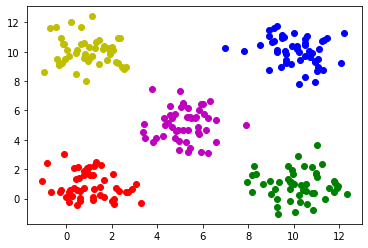

In [151]:
Xs = [[],[],[],[],[]]
Ys = [[],[],[],[],[]]
colors = ['r','b','g','y','m']


for i in range(len(X)):
    index = i % 5
    Xs[index].append(X[i,0])
    Ys[index].append(X[i,1])


plot.figure(num = 1)
for i in range(5):
    plot.scatter(Xs[i], Ys[i], c =colors[i])


In [152]:
sigma = np.std(X[:5]) #sigma should be representative of only a part of the data stream
sigmaInv = delta * (sigma) ** -1
#print(sigmaInv)
alpha = sigmaInv * np.identity(lenvectors)
covarDet = np.linalg.det(alpha) ** -1
#print(alpha)

alphas = {}
mus = {}
covDets = {}
comProbs = {}
ages = {}
accumulators ={}
correspondingData = {}

alphas[0] = alpha
covDets[0] = covarDet
mus[0] = X[0]
comProbs[0] = 1
ages[0] = 1
accumulators[0] = 1
K = 1
remainingK = D
correspondingData[0] = [0]
correspondingData[-1] = []

In [153]:
for i in range(len(X)):
    if i == 0:
        continue
    updated = False
    
    for j in range(K):
        if j >= K:
            break
        if (ages[j] > vmin) and (accumulators[j] < spmin):
            comProbs = remove(accumulators, ages, alphas, comProbs, correspondingData, covDets, j, mus, remainingK)
            remainingK += 1
            K -= 1
            print('call remove')
            print()
            
    for j in range(K):
        if i == j:
            continue
        
        print('(' + str(i) + ', ' + str(j) + ')')
        dist = myMahalanobis(X[i], mus[j], alphas[j]) ** 2
        #dist = distance.mahalanobis(X[i], mus[j], alphas[j]) ** 2
        print(dist)
        
        
        if dist < 1.064:
            print('call update')
            print()
            correspondingData[j].append(i)
            update(accumulators, ages, alphas, comProbs, covDets, D, j, K, mus, sigmaInv, X[i])
            updated = True
            
    if not updated and not remainingK == 0:
        print('call create')
        print()
        correspondingData[K] = [i]
        K = create(accumulators, ages, alphas, comProbs, covDets, K, mus, sigmaInv, X[i])
        remainingK -= 1

(1, 0)
1257.8144181157872
call create

(2, 0)
467.0188934005227
(2, 1)
938.4324183900748
call create

(3, 0)
178.6019976319487
(3, 1)
416.47048535263554
(3, 2)
2209.1872945342516
call create

(4, 0)
97.26484990289616
(4, 1)
75.6439724866725
(4, 2)
159.4246154271241
(4, 3)
145.64697731052976
call create

(5, 0)
0.09181625295666035
call update

dist = 0.09181625295666035
0.005705272231602664
0.43795620437956195
(5, 1)
1446.5744992171667
(5, 2)
343.6711950894221
(5, 3)
304.0170122416072
(5, 4)
114.03146171363377
(6, 0)
23010875.157362208
(6, 1)
0.01692983903410962
call update

dist = 0.01692983903410962
0.005922945685831722
0.27407784170012595
(6, 2)
1155.7293314946394
(6, 3)
513.3972545725495
(6, 4)
120.0081130268199
(7, 0)
467226.9446836817
(7, 1)
4.368653290718388
(7, 2)
0.9510100182014328
call update

dist = 0.9510100182014328
0.003712827878334318
0.19796648042266513
(7, 3)
1191.4632703873424
(7, 4)
48.41590069036454
(8, 0)
307216.87202382134
(8, 1)
195.89499739907893
(8, 2)
2119.3017


dist = 0.1153088230750019
0.006569541781439511
0.039366590609577444
(144, 3)
67.94853113567467
(144, 4)
161.95599769828564
(145, 0)
0.09318709839021203
call update

dist = 0.09318709839021203
0.05140735270467484
0.8824805554935712
(145, 1)
1625.564191398341
(145, 2)
51.51211468640002
(145, 3)
1.0131921586546477
call update

dist = 1.0131921586546477
0.0035991681430965995
0.019764265371173848
(145, 4)
1642.1410017362348
(146, 0)
312429716.0168198
(146, 1)
0.007609065079038925
call update

dist = 0.007609065079038925
0.006563585945160299
0.027690669462477665
(146, 2)
357.2317326419487
(146, 3)
82228.32166231572
(146, 4)
1.1203632116310827
(147, 0)
4191235.6852787486
(147, 1)
193.01275523310633
(147, 2)
87.86084267766556
(147, 3)
739.6385924221282
(147, 4)
802.8816467523203
(148, 0)
19869354.525730696
(148, 1)
0.7551533433234113
call update

dist = 0.7551533433234113
0.0047517676592765574
0.019128242892310007
(148, 2)
34.35884069770695
(148, 3)
3810.173756329839
(148, 4)
224.326463114415

In [32]:
#TODO find workaround for type for logsumexp
#print(accumulators)
#list1 = accumulators.values()
#print(sum(list1))
#scipy.special.logsumexp(np.array(list1))

In [154]:
print(K)
norms = np.ndarray([D + 1, K])
difference = 0
correspondences = np.ndarray(D + 1)
for i in range(D + 1): #D + 1 = len(startingMus)
    for j in range(K):
        norms[i, j] = np.linalg.norm(startingMus[i] - mus[j])
    index = np.argmin(norms[i])
    difference += norms[i,index]
    correspondences[i] = index
    print("mu = {}, sigma = {}".format(mus[index], np.linalg.inv(alphas[index])))
    print("starting mu = {}, starting Sigma = {}".format(startingMus[i], sigmas[i]))
    print("corresponding data = {}\n".format(correspondingData[index]))

    #print("mus ={}, sigmas = {}".format(mus[i],np.linalg.inv(alphas[i])))
    #print("startingmus = {}, startingSigmas ={}".format(startingMus[i],sigmas[i]))
    #print("corresponding data = {}".format(correspondingData[i]))

    #TODO handle case when
print(str(difference) + '\n')
print(correspondingData)

5
mu = [0.78552166 1.86082722], sigma = [[ 0.53575675 -0.52693445]
 [-0.52693445  0.53575675]]
starting mu = [1 1], starting Sigma = [[1. 0.]
 [0. 1.]]
corresponding data = [0, 5, 15, 50, 65, 75, 145]

mu = [5.92061134 6.37870958], sigma = [[ 0.25918423 -3.67295938]
 [-3.67295938  0.25918423]]
starting mu = [10 10], starting Sigma = [[1. 0.]
 [0. 1.]]
corresponding data = [209, 224, 234, 239, 244, 249]

mu = [9.74079757 2.17737033], sigma = [[ 2.71101632 -1.406733  ]
 [-1.406733    2.71101632]]
starting mu = [10  1], starting Sigma = [[1. 0.]
 [0. 1.]]
corresponding data = [222, 227, 232]

mu = [ 0.68676571 10.50813267], sigma = [[ 2.19688587 -1.79514197]
 [-1.79514197  2.19688587]]
starting mu = [ 1 10], starting Sigma = [[1. 0.]
 [0. 1.]]
corresponding data = [218, 228, 238, 243, 248]

mu = [5.92061134 6.37870958], sigma = [[ 0.25918423 -3.67295938]
 [-3.67295938  0.25918423]]
starting mu = [5 5], starting Sigma = [[1. 0.]
 [0. 1.]]
corresponding data = [209, 224, 234, 239, 244, 249]

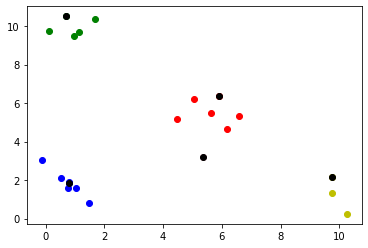

In [166]:
colors = ['b','r','g','y','pink']

for i in range(len(mus)):
    plot.figure(1)
    A = correspondingData[i]
    Xs_to_plot = X[A,0]
    Ys_to_plot = X[A,1]
    plot.scatter(Xs_to_plot, Ys_to_plot, c = colors[i])
    plot.scatter((mus[i][0]), (mus[i][1]), c = 'k')

#A = correspondingData[]

In [163]:
print(mus)
print(len(mus))

{0: array([0.78552166, 1.86082722]), 1: array([5.92061134, 6.37870958]), 2: array([ 0.68676571, 10.50813267]), 3: array([9.74079757, 2.17737033]), 4: array([5.36390304, 3.19958972])}
5


In [98]:
print(np.linalg.eig(np.linalg.inv(alphas[0])))
print(np.linalg.inv(alphas[0]))
print(distance.mahalanobis(X[10], mus[0], alphas[0]) ** 2)
print(np.linalg.inv(np.linalg.inv(alphas[0])))
print(alphas[0])
print(covDets)
print(np.linalg.det(np.linalg.inv(alphas[0])))

(array([ 0.91887529, -0.12039785]), array([[ 0.70710678,  0.70710678],
       [-0.70710678,  0.70710678]]))
[[ 0.39923872 -0.51963657]
 [-0.51963657  0.39923872]]
nan
[[-3.60875444 -4.69704141]
 [-4.69704141 -3.60875444]]
[[-3.60875444 -4.69704141]
 [-4.69704141 -3.60875444]]
{0: 0.048261490249873716, 1: 16.998616549633866, 2: 16.317564543064023, 3: 17.649099750385293, 4: 16.61346412800465}
-0.11063061293549876
